# HUMAN ACTIVITY RECGONICATION USING SMARTPHONE

##### ABOUT THE DATASET
 The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone  on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz.The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

###### Attribute Information:

For each record in the dataset it is provided:
- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
- Triaxial Angular velocity from the gyroscope.
- A 561-feature vector with time and frequency domain variables.
- Its activity label.
- An identifier of the subject who carried out the experiment

##### The raw data is not available. Instead, a pre-processed version of the dataset was made available.
###### The pre-processing steps included:
- Pre-processing accelerometer and gyroscope using noise filters.
- Splitting data into fixed windows of 2.56 seconds (128 data points) with 50% overlap.
- Splitting of accelerometer data into gravitational (total) and body motion components.

These signals were preprocessed for noise reduction with a median filter and a 3rd order low-pass Butterworth filter with a 20 Hz cutoff frequency.The acceleration signal, which has gravitational and body motion components, was separated using another Butterworth low-pass filter into body acceleration and gravity.

In [200]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel 

In [229]:
def human_test_data():
    testOrigin=pd.read_csv('C:/Users/ayush/Google Drive/Rutgers/Machine Learning/HumanActivity_test.csv')
    return(testOrigin)
testOrigin = human_test_data()

def human_train_data():
    trainOrigin=pd.read_csv('C:/Users/ayush/Google Drive/Rutgers/Machine Learning/HumanActivity_train.csv')
    return(trainOrigin)
trainOrigin = human_train_data()

In [235]:
def accelorameter_data(trainOrigin,task):
    IndexOfRowsOfLaying = (trainOrigin['Activity']==task) # return True and faulse
    dataLaying = trainOrigin[IndexOfRowsOfLaying] # extract columns related to activies
    dataLaying = dataLaying['tBodyAcc-mean()-X'] # only use mean value of accelerometer data in X direction
    dataLaying = dataLaying[:200] # pick the first 200 records
    ax = dataLaying.plot(subplots = True, figsize = (16,3),title = task)
    print(ax)
    return()

def data_cleaning(trainOrigin,testOrigin):
    print("Null Values in train data",trainOrigin.isnull().values.any())
    print("Null Values in test data",testOrigin.isnull().values.any())

def data_size(trainOrigin,testOrigin):
    print('training datast size:{}'.format(trainOrigin.shape),'\n\n')
    print('test datast size:{}'.format(testOrigin.shape),'\n\n')
    print(trainOrigin.Activity.value_counts(),'\n\n')
    print(testOrigin.Activity.value_counts(),'\n\n')
    print(trainOrigin['Activity'].value_counts(normalize=True) * 100,'\n\n')
    print(testOrigin['Activity'].value_counts(normalize=True) * 100,'\n\n')

In [237]:
def plot_data(trainOrigin):
    fig, ax = plt.subplots(ncols=2, figsize = (20,6))
    sns.countplot(trainOrigin['Activity'], ax=ax[0])
    sns.countplot(trainOrigin['subject'], ax=ax[1])
    ax[0].tick_params(axis='x', rotation=45)
    ax[0].set_ylabel('Number of observations')
    ax[0].set_title('Observations by activity')
    ax[1].set_ylabel('Number of observations')
    ax[1].set_title('Observations by subject')
    plt.show()
    
def data_variance_1(trainOrigin):
    subject28 = trainOrigin.loc[trainOrigin['subject']==28]
    graph = plt.figure(figsize = (32,24))
    ax1 = graph.add_subplot(221) # fist graph location
    ax1 = sns.stripplot(x = 'Activity', y = subject28.iloc[:,0], data = subject28, jitter = True) 
    # pick column [0] which is ACC-mean()-X
    ax2 = graph.add_subplot(222) # second graph location
    ax2 = sns.stripplot(x = 'Activity', y = subject28.iloc[:,1], data = subject28, jitter = True)
    # pick column [1] which is ACC-mean()-Y

def data_variance_2(trainOrigin): 
    graph2 = plt.figure(figsize = (32,24))
    ax1 = graph2.add_subplot(221)
    ax1 = sns.stripplot(x = 'Activity', y = subject28.iloc[:,9], data = subject28, jitter = True)
    # pick column [9] which is ACC-max()-X
    ax2 = graph2.add_subplot(222)
    ax2 = sns.stripplot(x = 'Activity', y = subject28.iloc[:,10], data = subject28, jitter = True)
    # pick column [10] which is ACC-max()-Y
    plt.show()


In [238]:
le = LabelEncoder()
 
X_train = trainOrigin.iloc[:,0:(trainOrigin.shape[1]-2)].values
y_train = le.fit_transform(trainOrigin.iloc[:,trainOrigin.shape[1]-1].values)
 
X_test = testOrigin.iloc[:,0:(testOrigin.shape[1]-2)].values
y_test = le.transform(testOrigin.iloc[:,testOrigin.shape[1]-1].values)

In [239]:
def tSne(X_train,y_train):
    from sklearn.manifold import TSNE
    tsne = TSNE()
    train_reduced = tsne.fit_transform(X_train)

    tsne_data = pd.DataFrame(
        {'X':train_reduced[:,0], 'Y':train_reduced[:,1], 
         'activity':trainOrigin['Activity']})

    activities = tsne_data['activity'].unique()
    colormap = ['b', 'g', 'r', 'c', 'm', 'y']

    fig, ax = plt.subplots(figsize=(12,12))
    for i in range(len(activities)):
        plot_data = tsne_data.loc[tsne_data['activity'] == activities[i]]
        ax.scatter('X', 'Y', data=plot_data, color=colormap[i], label=activities[i])
    ax.set_title('2-dimensional $t$-SNE embedding of accelerometer data')
    ax.legend()
    plt.show()
    return

In [242]:
def split(trainOrigin,testOrigin):
    trainData, trainActivity = trainOrigin.iloc[:,0:len(trainOrigin.columns)-1],trainOrigin.iloc[:,-1]
    testData, testActivity = testOrigin.iloc[:,0:len(testOrigin.columns)-1],testOrigin.iloc[:,-1]
    return(trainData, trainActivity, testData, testActivity)

In [245]:
def knn(trainData, trainActivity, testData, testActivity):
    
    from sklearn.neighbors import KNeighborsClassifier as knn
    
    knnclf = knn(n_neighbors = 15, weights='distance')
    knnModel = knnclf.fit(trainData , trainActivity)
    Knntestscore = knnModel.score(testData  , testActivity )
    crossKNN = cross_val_score(knnclf,trainData,trainActivity, cv=20).mean()
    
    print("Testing set score for KNN: ",Knntestscore)
    print("Training set score for KNN: ",crossKNN,"\n")

    KnnPred = knnModel.predict(testData)
    array = confusion_matrix(KnnPred,testActivity)
    print('Comfusion_Matrix',array)
    glm_cm1 = pd.DataFrame(array, range(6),range(6))
    glm_cm1.columns = ["LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"]
    glm_cm1.index = ["LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"]
    print(glm_cm1)
    return(Knntestscore,crossKNN)

In [247]:
def logistic(trainData, trainActivity, testData, testActivity):   
    
    glmClassifier = LogisticRegression(random_state = 0)
    glmClassifier.fit(trainData, trainActivity)
    trainscore = cross_val_score(glmClassifier,trainData,trainActivity, cv=20).mean()
    
    # Predicting the Test set results
    glm_pred_test = glmClassifier.predict(testData)

    # Making the Confusion Matrix
    
    confusionMatrix = confusion_matrix(testActivity, glm_pred_test)
    accuracy_score_test = accuracy_score(testActivity,glm_pred_test)

    print(confusionMatrix)
    print("Test set score for Logistic Regression:", accuracy_score_test)
    print("Training set score for Logistic Regression:", trainscore)
    
    array = confusion_matrix(glm_pred_test,testActivity)
    glm_cm = pd.DataFrame(array, range(6),range(6))
    glm_cm.columns = ["LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"]
    glm_cm.index = ["LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"]
    sns.heatmap(glm_cm, annot=True,annot_kws={"size": 12},yticklabels=("LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"), xticklabels=("LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"))# font size
    plt.show()
    return(confusionMatrix,trainscore,accuracy_score_test,glm_cm)



In [1]:
def SVM(trainData, trainActivity, testData, testActivity):
    
    params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                         'C': [1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    svm_model_origin = GridSearchCV(SVC(), params_grid, cv=5)
    svm_model_origin.fit(trainData, trainActivity)
    print('Best score for training data:', svm_model_origin.best_score_,"\n") 

    # View the best parameters for the model found using grid search
    print('Best C:',svm_model_origin.best_estimator_.C,"\n") 
    print('Best Kernel:',svm_model_origin.best_estimator_.kernel,"\n")
    print('Best Gamma:',svm_model_origin.best_estimator_.gamma,"\n")

    final_model_origin = svm_model_origin.best_estimator_
    trainscoreSVC = cross_val_score(final_model_origin,trainData,trainActivity, cv=20).mean()
    svc_pred_origin = final_model_origin.predict(testData)
    testscoreSVC = final_model_origin.score(testData, testActivity )


    # Making the Confusion Matrix
    print(confusion_matrix(testActivity,svc_pred_origin))
    print("\n")
    print(classification_report(testActivity,svc_pred_origin))

    print("Training set score for SVM: ",trainscoreSVC)
    print("Testing  set score for SVM: ",testscoreSVC)
    print(svm_model_origin.best_estimator_)
    array = confusion_matrix(svc_pred_origin,testActivity)
    svc_cm = pd.DataFrame(array, range(6),range(6))
    svc_cm.columns = ["LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"]
    svc_cm.index = ["LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"]
    return(trainscoreSVC,testscoreSVC,svc_cm)

In [250]:
def accuracy(Knntestscore,accuracy_score_test,testscoreSVC,crossKNN,trainscore,trainscoreSVC):
    algorithms = ['KNN', "LogisticRegression", "SVC"]
    

    scorestest = [Knntestscore,accuracy_score_test,testscoreSVC]
    score_dataTest = pd.DataFrame({'Algorithm': algorithms, 'Score': scorestest}).set_index('Algorithm')
    warnings.filterwarnings('ignore')
    fig = plt.figure(figsize=(5,5)) # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes
    width = .4
    score_dataTest.Score.plot(kind='bar',color='c', ax=ax,width = width,position=0)

    ax.grid(None)
    ax.set_ylabel('Test Accuracy')
    
    ax.set_xlim(-1,3)
    plt.show()

In [252]:
def random_forest(trainData, trainActivity):
    
    sel = SelectFromModel(RandomForestClassifier())
    sel.fit(trainData, trainActivity)
    selected_feat= trainData.columns[(sel.get_support())] 
    len(selected_feat)
    print(selected_feat)
    
    importances = sel.estimator_.feature_importances_
    pd.Series(importances.ravel()).hist()
    return(sel)

def reduced_feature_data(trainData,testData,sel):
    
    rfTree_featuresTrain = trainData.loc[:,sel.get_support()] 
    rfTree_featuresTest = testData.loc[:,sel.get_support()]
    return(rfTree_featuresTrain,rfTree_featuresTest)

In [259]:
def logistic_rf(rfTree_featuresTrain,rfTree_featuresTest,trainActivity,testActivity):
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,f1_score
    
    classifier = LogisticRegression(random_state = 0)
    classifier.fit(rfTree_featuresTrain, trainActivity)

    # Predicting the Test set results
    y_pred = classifier.predict(rfTree_featuresTest)

    # Making the Confusion Matrix
    cm = confusion_matrix(testActivity, y_pred)
    accuracy_score=accuracy_score(testActivity,y_pred)
    recall_score=recall_score(testActivity,y_pred,average='weighted')# tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives.
                                                                    # The recall is intuitively the ability of the classifier to find all the positive samples.

    print(y_pred)
    print("ConfusionMatrix",cm)
    print("TestAccuracy",accuracy_score)
    print("RecallScore",recall_score)
    
    array = confusion_matrix(y_pred,testActivity)
    glmAfter_cm = pd.DataFrame(array, range(6),range(6))
    glmAfter_cm.columns = ["LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"]
    glmAfter_cm.index = ["LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"]
    print(glmAfter_cm)

In [261]:
def SVM_rf(rfTree_featuresTrain,rfTree_featuresTest,trainActivity,testActivity):
    
    from sklearn.svm import SVC
    from sklearn.metrics import confusion_matrix,classification_report
    from sklearn.model_selection import cross_val_score, GridSearchCV
    
    params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                         'C': [1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    svm_model = GridSearchCV(SVC(), params_grid, cv=5)
    svm_model.fit(rfTree_featuresTrain, trainActivity)
    print('Best score for training data:', svm_model.best_score_,"\n") 

    # View the best parameters for the model found using grid search
    print('Best C:',svm_model.best_estimator_.C,"\n") 
    print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
    print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

    final_model = svm_model.best_estimator_
    Y_pred = final_model.predict(rfTree_featuresTest)
    #Y_pred_label = list(encoder.inverse_transform(Y_pred))

    # Making the Confusion Matrix
    print(confusion_matrix(testActivity,Y_pred))
    print("\n")
    print(classification_report(testActivity,Y_pred))

    print("Training set score for SVM: %f" % final_model.score(rfTree_featuresTrain , trainActivity))
    print("Testing  set score for SVM: %f" % final_model.score(rfTree_featuresTest , testActivity ))
    
    array = confusion_matrix(Y_pred,testActivity)
    svcAfter_cm = pd.DataFrame(array, range(6),range(6))
    svcAfter_cm.columns = ["LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"]
    svcAfter_cm.index = ["LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"]

In [277]:
def PCA(trainData):
    
    from sklearn.decomposition import PCA
    pca = PCA(n_components=len(trainData.columns))
    pca_traindata = pca.fit(trainData)

    # Visualize PCA result
    plt.plot(np.cumsum(pca_traindata.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    np.cumsum(pca_traindata.explained_variance_ratio_)

In [278]:
def reduced_PCA(trainData,testData):
    
    from sklearn.decomposition import PCA
    pca81 = PCA(n_components = 81)
    pca_traindata81 = pca81.fit(trainData)
    pcatrain = pca_traindata81.transform(trainData)
    pcatest = pca_traindata81.transform(testData)
    return(pcatrain,pcatest)

In [280]:
def logistic_PCA(pcatrain,trainActivity,pcatest,testActivity):
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,f1_score
    
    # Predicting the Test set results after appling PCA on the rftee data set
    classifier_PCA = LogisticRegression(random_state = 0)
    classifier_PCA.fit(pcatrain, trainActivity)


    y_pred_PCA = classifier_PCA.predict(pcatest)

    # Making the Confusion Matrix
    cm_PCA = confusion_matrix(testActivity, y_pred_PCA)
    accuracy_score_PCA=accuracy_score(testActivity,y_pred_PCA)
    recall_score_PCA=recall_score(testActivity,y_pred_PCA,average='weighted')
    # tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives.
    # The recall is intuitively the ability of the classifier to find all the positive samples.

    print(y_pred_PCA,"\n")
    print("ComfusionMatrix",cm_PCA,"\n")
    print("TestAccuracy",accuracy_score_PCA,"\n")
    array = confusion_matrix(y_pred_PCA,testActivity)
    glm_pca_cm = pd.DataFrame(array, range(6),range(6))
    glm_pca_cm.columns = ["LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"]
    glm_pca_cm.index = ["LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"]
    print(glm_pca_cm)

In [282]:
def SVM_PCA(pcatrain,trainActivity,pcatest,testActivity):
    params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    svm_model_pca = GridSearchCV(SVC(), params_grid, cv=5)
    svm_model_pca.fit(pcatrain, trainActivity)
    print('Best score for training data:', svm_model_pca.best_score_,"\n") 

    # View the best parameters for the model found using grid search
    print('Best C:',svm_model_pca.best_estimator_.C,"\n") 
    print('Best Kernel:',svm_model_pca.best_estimator_.kernel,"\n")
    print('Best Gamma:',svm_model_pca.best_estimator_.gamma,"\n")

    final_model_pca = svm_model_pca.best_estimator_
    Y_pred_pca = final_model_pca.predict(pcatest)
    #Y_pred_label = list(encoder.inverse_transform(Y_pred))

    # Making the Confusion Matrix
    #print(pd.crosstab(Y_test_label, Y_pred_label, rownames=['Actual Activity'], colnames=['Predicted Activity']))
    print(confusion_matrix(testActivity,Y_pred_pca))
    print("\n")
    print(classification_report(testActivity,Y_pred_pca))

    print("Testing  set score for SVM: %f" % final_model_pca.score(pcatest , testActivity ))
    array = confusion_matrix(Y_pred_pca,testActivity)
    svc_pca_cm = pd.DataFrame(array, range(6),range(6))
    svc_pca_cm.columns = ["LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"]
    svc_pca_cm.index = ["LAYING", "SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIR"]
    print(svc_pca_cm)

### ------Examine the data------

In [171]:
trainOrigin.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


#### ----- Checking Null Values -----

In [236]:
data_cleaning(trainOrigin,trainOrigin)

Null Values in train data False
Null Values in test data False


#### ----- Checking Data Size -----

In [234]:
data_size(human_train_data(),human_test_data())

training datast size:(7352, 563) 


test datast size:(2947, 563) 


LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64 


LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: Activity, dtype: int64 


LAYING                19.137650
STANDING              18.688792
SITTING               17.491839
WALKING               16.675734
WALKING_UPSTAIRS      14.594668
WALKING_DOWNSTAIRS    13.411317
Name: Activity, dtype: float64 


LAYING                18.221921
STANDING              18.052257
WALKING               16.830675
SITTING               16.661011
WALKING_UPSTAIRS      15.982355
WALKING_DOWNSTAIRS    14.251781
Name: Activity, dtype: float64 




###### Visualizing and Analyzing the data
###### How does the accelorameter data looks for LAYING, SITTING, STANDING, WALKING, WALKING UPSTAIRS, WALKING DOWNSTAIRS ?
For Laying, Sitting and Standing the accelerometer reading looks almost same and steady, beacuse the velocity is zero.
For Walking, Walking Upstairs and Walking Downstairs the accelerometer reading are different and fluctuating from the other acctivities, as the velocity is not zero. 

()

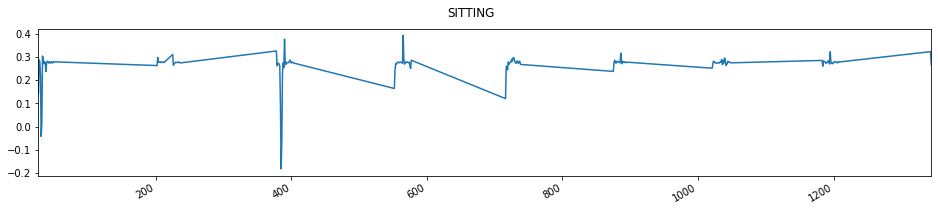

In [160]:
accelorameter_data(trainOrigin,'SITTING')

()

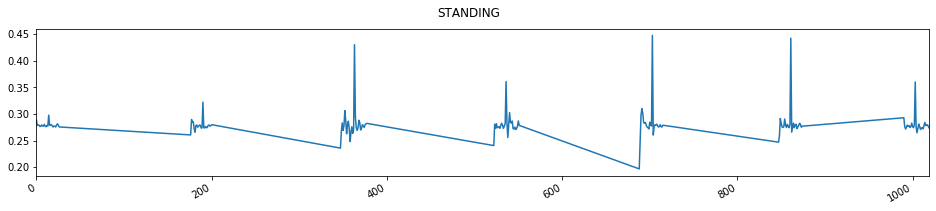

In [161]:
accelorameter_data(trainOrigin,'STANDING')

()

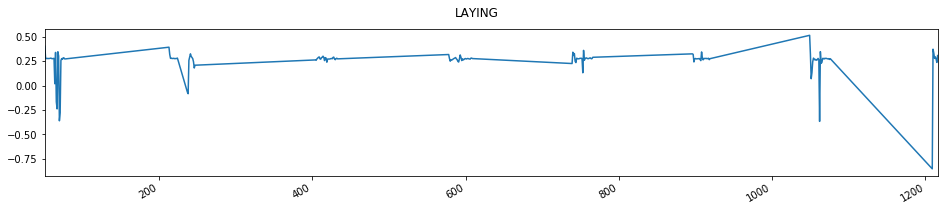

In [162]:
accelorameter_data(trainOrigin,'LAYING')

()

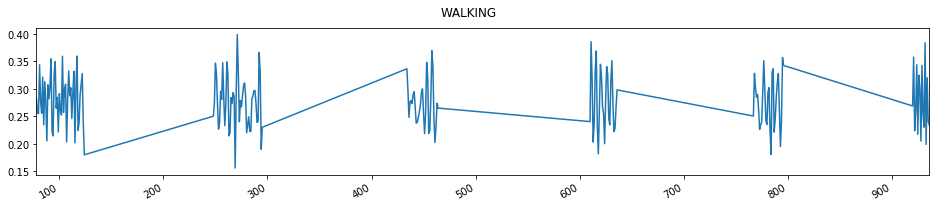

In [163]:
accelorameter_data(trainOrigin,'WALKING')

()

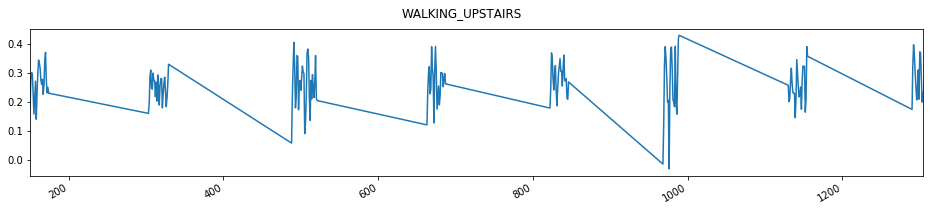

In [164]:
accelorameter_data(trainOrigin,'WALKING_UPSTAIRS')

()

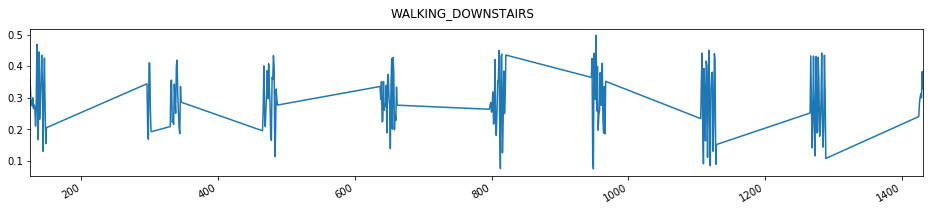

In [165]:
accelorameter_data(trainOrigin,'WALKING_DOWNSTAIRS')

##### ------To get a better understanding of the dataset------
- There are 7352 observations.
- These observations have been taken for 21 users

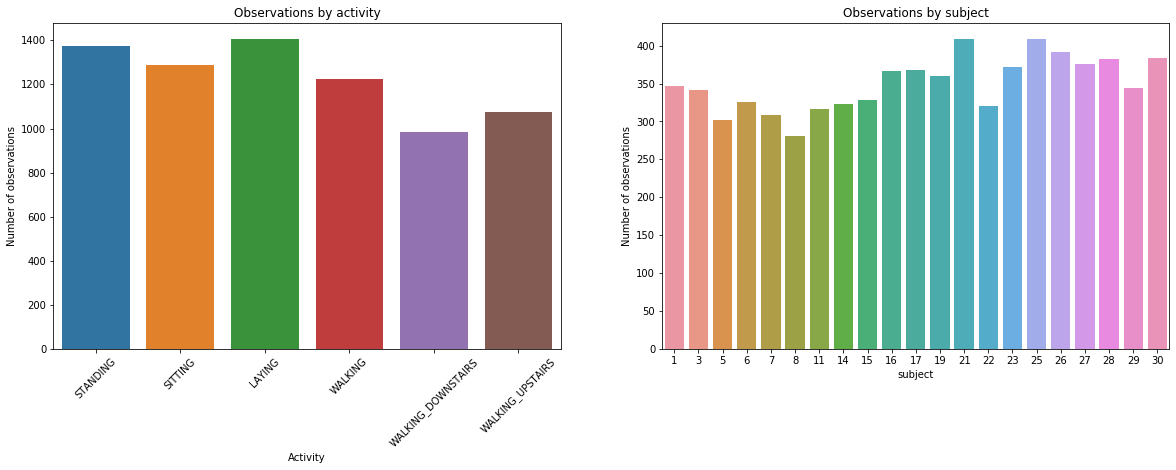

In [178]:
plot_data(trainOrigin)

##### Since the data is almost evenly distributed for all the activities among all the subjects, we have picked subject 28 to compare the activity.

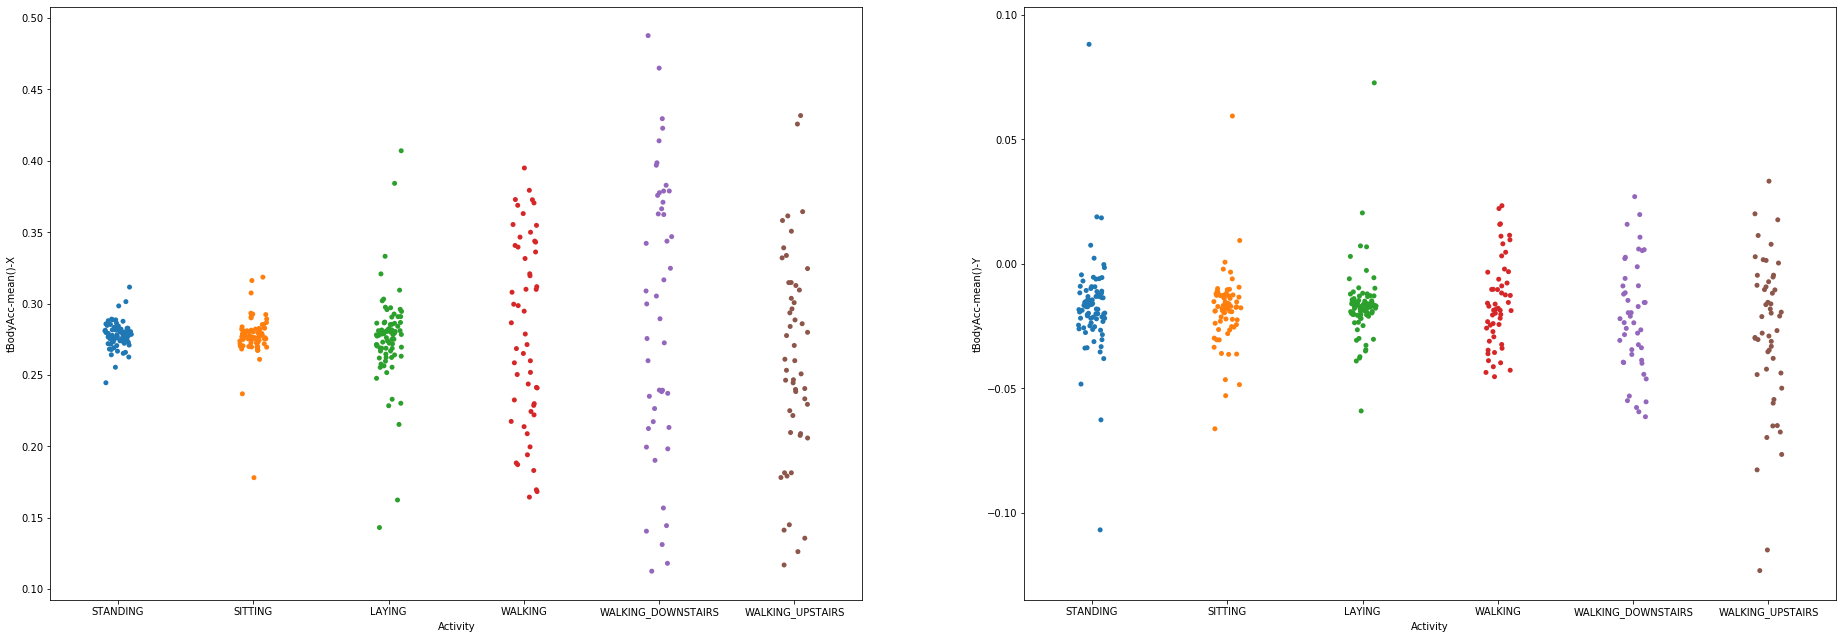

In [183]:
data_variance_1(trainOrigin)

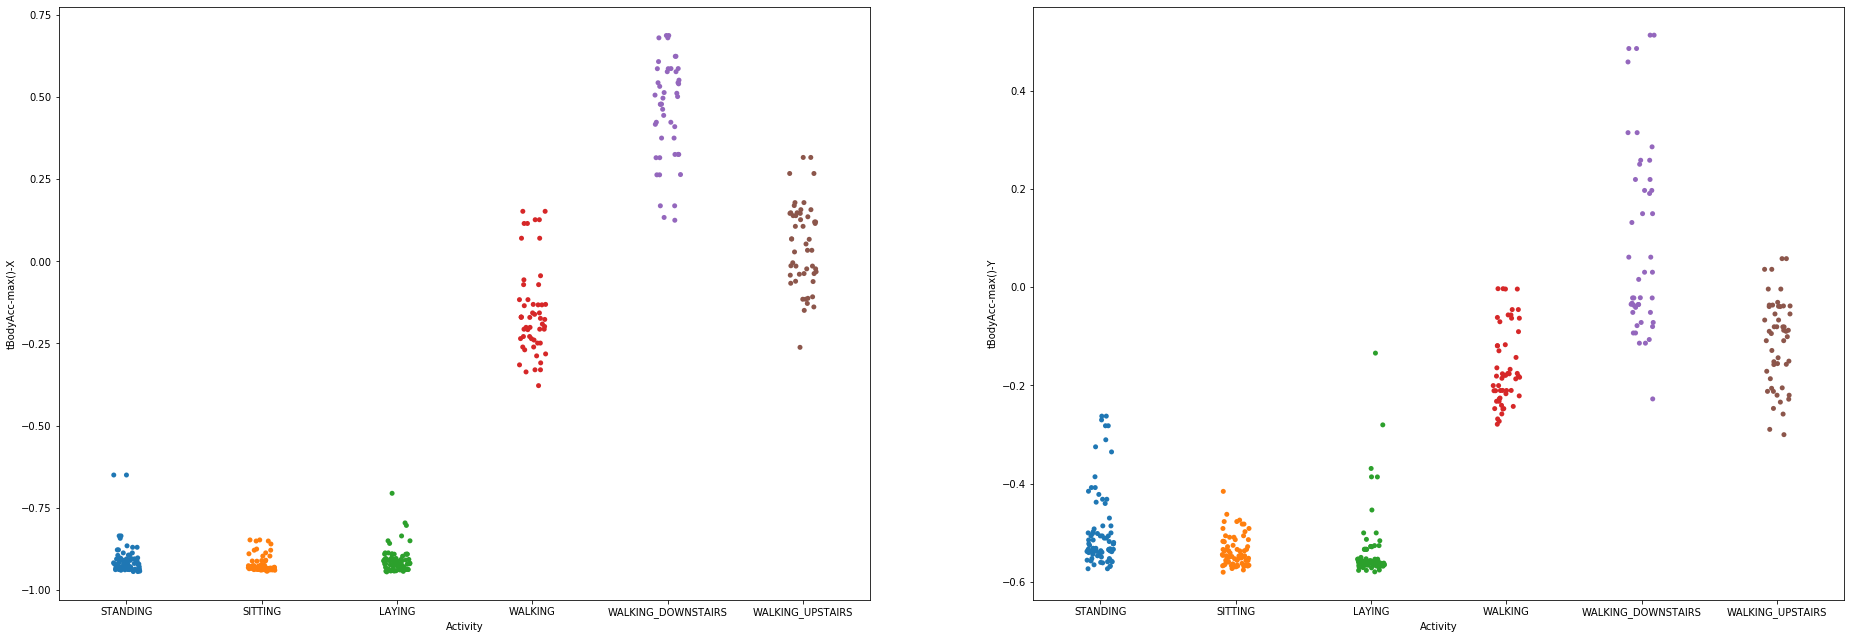

In [184]:
data_variance_2(trainOrigin)

###### The variation of Walking, Walking Upstairs, Walking Downstair are high and for other activities it is low

#### ----- Using t-SNE to see the 2-D visualization of accelerometer data -----
As we can see in the below graph that the sitting and standing avtivity data points are overlapping, ie. the reading of acceleormeter data for sitting and standing is almost similar and it is difficult to identify sitting and standing beacuse of that. And the misclassification rate of sitting and standing is very high.

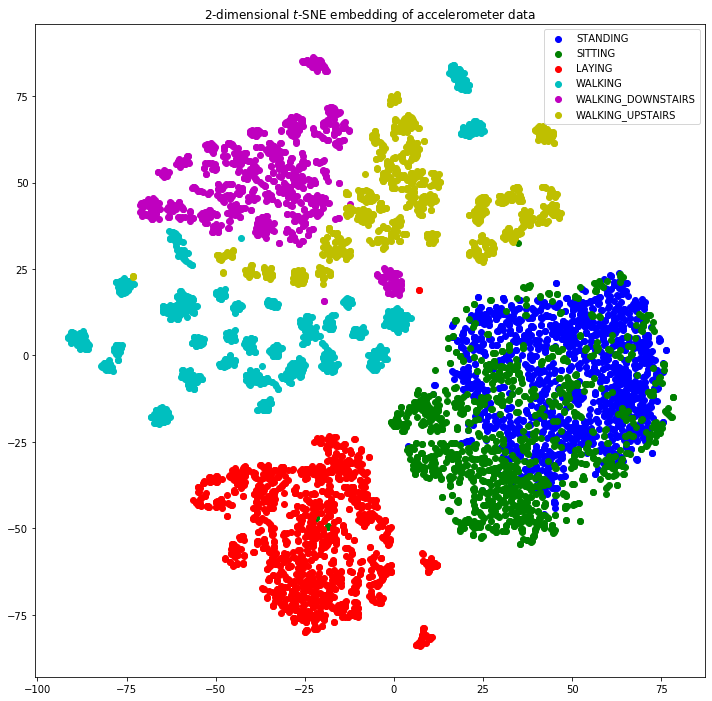

In [188]:
tSne(X_train,y_train)

#### ----- Data Split -----

In [241]:
trainData, trainActivity, testData, testActivity = split(trainOrigin,testOrigin)

#### ----- Perform KNN On whole Dataset -----

In [244]:
Knntestscore,crossKNN = knn(trainData, trainActivity, testData, testActivity)

Testing set score for KNN:  0.8154054971157109
Training set score for KNN:  0.8562530837270061 

                    LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
LAYING                 510        0         0        0                   0   
SITTING                 21      337        52        0                   0   
STANDING                 5      152       479        0                   0   
WALKING                  0        0         1      433                  73   
WALKING_DOWNSTAIRS       0        0         0       38                 304   
WALKING_UPSTAIR          1        2         0       25                  43   

                    WALKING_UPSTAIR  
LAYING                            0  
SITTING                           0  
STANDING                          0  
WALKING                         109  
WALKING_DOWNSTAIRS               22  
WALKING_UPSTAIR                 340  
Testing set score for KNN:  0.8154054971157109
Training set score for KNN:  0.856253083727

#### ----- Perform Logistic Regression on whole dataset -----

[[537   0   0   0   0   0]
 [  0 429  59   0   0   3]
 [  0  13 517   2   0   0]
 [  0   0   0 494   2   0]
 [  0   0   0   4 407   9]
 [  0   0   0  22   0 449]]
Test set score for Logistic Regression: 0.9613165931455717
Training set score for Logistic Regression: 0.9595008863648535


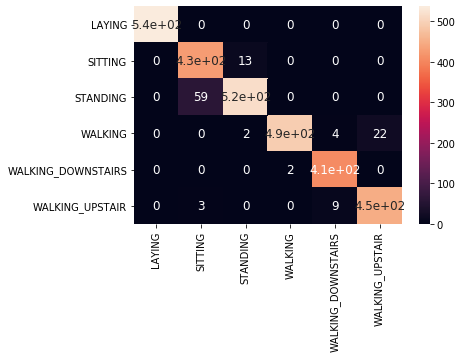

In [248]:
confusionMatrix,trainscore,accuracy_score_test,glm_cm = logistic(trainData, trainActivity, testData, testActivity)

#### ----- Perform Support Vector Machine (Multi Class) on whole Data Set ----- 

In [249]:
trainscoreSVC,testscoreSVC,svc_cm = SVM(trainData, trainActivity, testData, testActivity)

Best score for training data: 0.9360718171926007 

Best C: 1 

Best Kernel: linear 

Best Gamma: auto_deprecated 

[[537   0   0   0   0   0]
 [  0 435  55   0   0   1]
 [  0  16 516   0   0   0]
 [  0   0   0 494   1   1]
 [  0   0   0   4 410   6]
 [  0   0   0  22   2 447]]


                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.89      0.92       491
          STANDING       0.90      0.97      0.94       532
           WALKING       0.95      1.00      0.97       496
WALKING_DOWNSTAIRS       0.99      0.98      0.98       420
  WALKING_UPSTAIRS       0.98      0.95      0.97       471

          accuracy                           0.96      2947
         macro avg       0.97      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Training set score for SVM:  0.964970826949647
Testing  set score for SVM:  0.9633525619273838
SVC(C=1, cache_size=20

#### ----- Test Accuracy of all the models -----

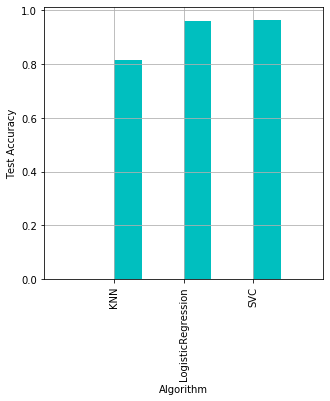

In [251]:
accuracy(Knntestscore,accuracy_score_test,testscoreSVC,crossKNN,trainscore,trainscoreSVC)

#### ----- Random Forest Feature Selection -----

Index(['tBodyAcc-mad()-X', 'tBodyAcc-max()-X', 'tBodyAcc-energy()-X',
       'tBodyAcc-correlation()-X,Y', 'tBodyAcc-correlation()-Y,Z',
       'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-mean()-Z',
       'tGravityAcc-std()-Y', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y',
       'tGravityAcc-max()-Z', 'tGravityAcc-min()-X', 'tGravityAcc-min()-Y',
       'tGravityAcc-min()-Z', 'tGravityAcc-energy()-X',
       'tGravityAcc-energy()-Y', 'tGravityAcc-energy()-Z',
       'tGravityAcc-entropy()-X', 'tGravityAcc-entropy()-Y',
       'tGravityAcc-arCoeff()-X,1', 'tGravityAcc-arCoeff()-X,2',
       'tGravityAcc-arCoeff()-Y,1', 'tGravityAcc-arCoeff()-Y,4',
       'tGravityAcc-arCoeff()-Z,1', 'tGravityAcc-arCoeff()-Z,2',
       'tGravityAcc-arCoeff()-Z,3', 'tGravityAcc-correlation()-X,Y',
       'tBodyAccJerk-std()-Z', 'tBodyAccJerk-max()-X',
       'tBodyAccJerk-energy()-X', 'tBodyAccJerk-iqr()-X', 'tBodyGyro-max()-X',
       'tBodyGyro-min()-X', 'tBodyGyro-energy()-X', 'tBody

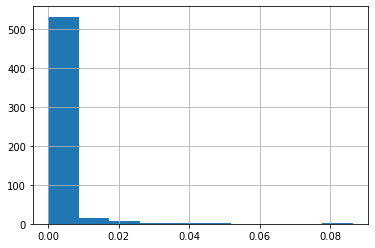

In [256]:
sel = random_forest(trainData, trainActivity)

##### ----- Based on Feature Selection only 85 features were selected -----


SelectFromModel will select those features which importance is greater than the mean importance of all the features by default, but we can alter this threshold if we want. Then I use selectFromModel object from sklearn to automatically select the features.

#### ----- Reduced Feature Data -----

In [257]:
rfTree_featuresTrain,rfTree_featuresTest = reduced_feature_data(trainData,testData,sel)

#### ----- Perform Logistic Regression on reduced-features data -----

In [260]:
logistic_rf(rfTree_featuresTrain,rfTree_featuresTest,trainActivity,testActivity)

['STANDING' 'STANDING' 'STANDING' ... 'WALKING_UPSTAIRS'
 'WALKING_UPSTAIRS' 'WALKING_UPSTAIRS']
ConfusionMatrix [[516   0  20   0   0   1]
 [  0 370 117   0   0   4]
 [  0  68 463   1   0   0]
 [  0   0   0 494   1   1]
 [  0   0   0  13 376  31]
 [  0   0   0  32   5 434]]
TestAccuracy 0.9002375296912114
RecallScore 0.9002375296912114
                    LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
LAYING                 516        0         0        0                   0   
SITTING                  0      370        68        0                   0   
STANDING                20      117       463        0                   0   
WALKING                  0        0         1      494                  13   
WALKING_DOWNSTAIRS       0        0         0        1                 376   
WALKING_UPSTAIR          1        4         0        1                  31   

                    WALKING_UPSTAIR  
LAYING                            0  
SITTING                           0  


#### ----- Perform Support Vector Machine (Multi Class) on reduced-features data -----

In [262]:
SVM_rf(rfTree_featuresTrain,rfTree_featuresTest,trainActivity,testActivity)

Best score for training data: 0.9151251360174102 

Best C: 1000 

Best Kernel: linear 

Best Gamma: auto_deprecated 

[[537   0   0   0   0   0]
 [  0 391  98   0   0   2]
 [  0  35 497   0   0   0]
 [  0   0   0 487   8   1]
 [  0   0   0   7 388  25]
 [  0   0   0  53  11 407]]


                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.80      0.85       491
          STANDING       0.84      0.93      0.88       532
           WALKING       0.89      0.98      0.93       496
WALKING_DOWNSTAIRS       0.95      0.92      0.94       420
  WALKING_UPSTAIRS       0.94      0.86      0.90       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947

Training set score for SVM: 0.975245
Testing  set score for SVM: 0.918561


##### ----- PCA  Feature Selection -----

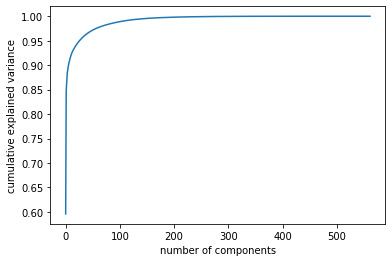

In [274]:
PCA(trainData)

##### ----- Based on the PCA feature selection 81 features selected -----

##### ----- Reduced Feature Data after performing PCA -----

In [279]:
pcatrain,pcatest = reduced_PCA(trainData,testData)

##### ----- Perform Logistic Regression after performing PCA -----

In [281]:
logistic_PCA(pcatrain,trainActivity,pcatest,testActivity)

['STANDING' 'STANDING' 'STANDING' ... 'WALKING_UPSTAIRS'
 'WALKING_UPSTAIRS' 'WALKING'] 

ComfusionMatrix [[537   0   0   0   0   0]
 [  0 419  68   0   0   4]
 [  0  21 510   1   0   0]
 [  0   0   0 493   3   0]
 [  0   0   0   3 405  12]
 [  0   0   0  35   9 427]] 

TestAccuracy 0.9470648116728877 

                    LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
LAYING                 537        0         0        0                   0   
SITTING                  0      419        21        0                   0   
STANDING                 0       68       510        0                   0   
WALKING                  0        0         1      493                   3   
WALKING_DOWNSTAIRS       0        0         0        3                 405   
WALKING_UPSTAIR          0        4         0        0                  12   

                    WALKING_UPSTAIR  
LAYING                            0  
SITTING                           0  
STANDING                          

##### ----- Perform Support Vector Machine (Multi Class) after performing PCA -----

In [283]:
SVM_PCA(pcatrain,trainActivity,pcatest,testActivity)

Best score for training data: 0.9164853101196954 

Best C: 1 

Best Kernel: linear 

Best Gamma: auto_deprecated 

[[537   0   0   0   0   0]
 [  0 421  69   0   0   1]
 [  0  26 506   0   0   0]
 [  0   0   0 488   8   0]
 [  0   0   0   8 398  14]
 [  0   0   0  36  13 422]]


                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.94      0.86      0.90       491
          STANDING       0.88      0.95      0.91       532
           WALKING       0.92      0.98      0.95       496
WALKING_DOWNSTAIRS       0.95      0.95      0.95       420
  WALKING_UPSTAIRS       0.97      0.90      0.93       471

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947

Testing  set score for SVM: 0.940618
                    LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
LA